# Carls' Implementation of QAOA

References:

https://qiskit.org/textbook/ch-applications/qaoa.html

In [6]:
#!pip3 install qiskit
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram


from scipy.optimize import minimize

from pytket.extensions.quantinuum import QuantinuumBackend
backend = QuantinuumBackend(device_name="H1-2E")
backend.login()
print(backend.device_state(device_name="H1-2E"))

Enter your Quantinuum email:  oapte@usc.edu
Enter your Quantinuum password:  ········


online


## Create QUBO Instance

We first create an instance of a Quadratic Unconstrained Binary Optimization problem.

In this example, we solve the Max-Cut problem

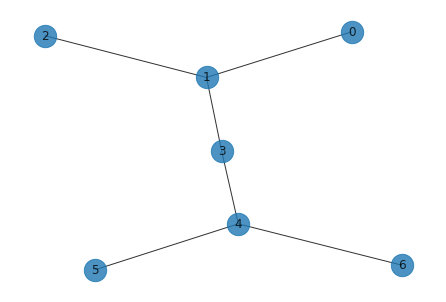

In [7]:
n_qubits = 7
p = 1
shots = 1000
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3,4,5])
# G.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (3, 4), (4,5), (4,6)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

## Convert to Quantum Circuit

### Create Mixing Quantum Circuit

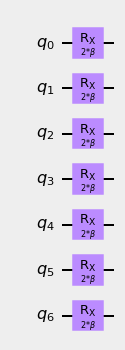

In [8]:
def create_mixing_qc(n_qubits, beta):
    qc_mix = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix

qc = create_mixing_qc(n_qubits, Parameter("$\\beta$"))

circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})

        

### Create Problem Quantum Circuit

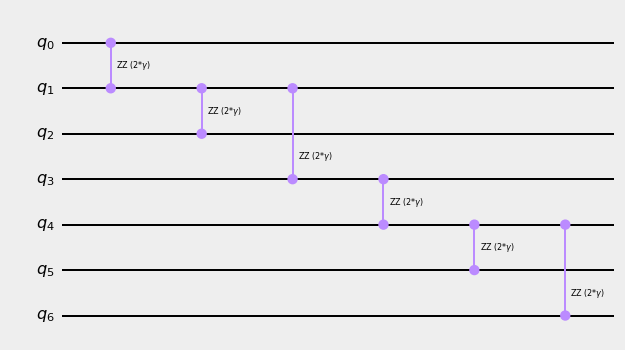

In [9]:
def create_graph_problem_qc(G, n_qubits, gamma):
    qc_p = QuantumCircuit(n_qubits)
    for pair in list(G.edges()):  # pairs of nodes
        qc_p.rzz(2 * gamma, pair[0], pair[1])
        # qc_p.barrier()
    return qc_p

qc = create_graph_problem_qc(G, n_qubits, Parameter("$\\gamma$"))
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create Initial State

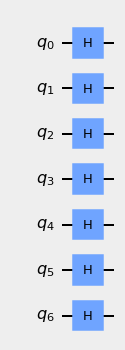

In [10]:
def create_initial_qc(n_qubits):
    qc_0 = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_0.h(i)
    return qc_0

qc = create_initial_qc(n_qubits)
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Combine into QAOA Circuit

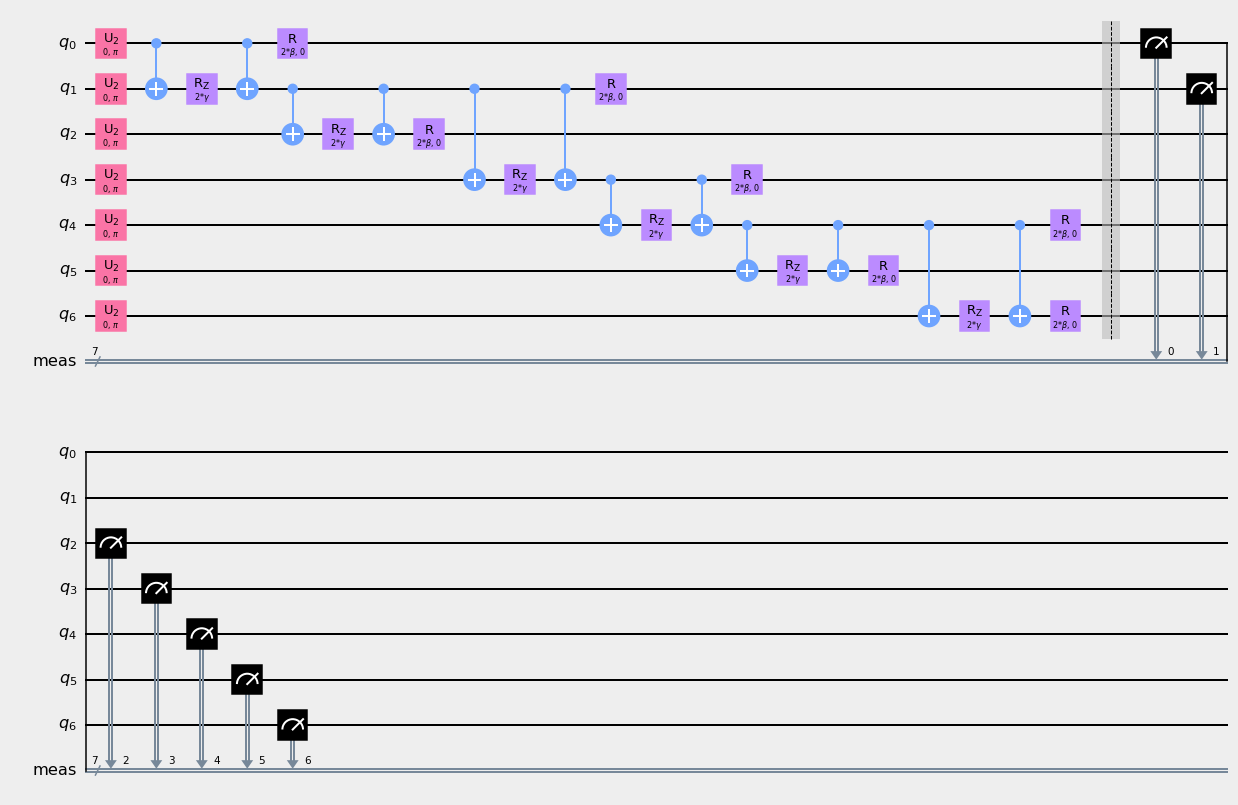

In [11]:
def create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator, 
                     beta_list, gamma_list):
    qc = QuantumCircuit(n_qubits)
    
    # Add initial state and specify which qubits to attach
    attach_qubits = [i for i in range(0, n_qubits)]
    qc.append(create_initial_qc(n_qubits), attach_qubits[:])
    
    assert len(beta_list) == len(gamma_list), 'Beta and gamma list must \
        be the same length'
    n_reps = len(beta_list)
    
    # Now add repeated applications of problem and mixing circuits
    for rep in range(0, n_reps):
        qc.append(problem_qc_generator(n_qubits, gamma_list[rep]), attach_qubits[:])
        qc.append(mixing_qc_generator(n_qubits, beta_list[rep]), attach_qubits[:])
    
    qc.measure_all()
    return qc

beta = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")
beta_list = [beta for _ in range(p)]
gamma_list = [gamma for _ in range(p)]

# Define wrappers for problem qc and mixing qc generator.
# This allows us to solve a variety of QUBO problems with the same stack.
def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)


qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                      beta_list, gamma_list)

# Decompose to show individual elements, then draw
circuit_drawer(qc.decompose().decompose(), output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create helper method to calculate expection

In [12]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


def get_expectation(problem_qc_generator, mixing_qc_generator, n_qubits, shots=512):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    
    def execute_circ(theta):
        midpt = len(theta) // 2
        beta_list = theta[:midpt]
        gamma_list = theta[midpt:]
        
        qc = create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator,
                          beta_list, gamma_list)
        # Have to decompose in order to run backend
        counts = backend.run(qc.decompose().decompose(), seed_simulator=10, 
                             shots=shots).result().get_counts()

        return compute_expectation(counts, G)
    
    return execute_circ

def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

# This returns a function which can optimize classically
get_expectation(graph_qc_generator, mixing_qc_generator, n_qubits, shots)


<function __main__.get_expectation.<locals>.execute_circ(theta)>

### Run QAOA

In [13]:
def qaoa(problem_qc_generator, mixing_qc_generator, n_qubits, shots):
    
    expectation = get_expectation(problem_qc_generator, mixing_qc_generator, 
                                  n_qubits, shots)

    initial_theta_value = [1.0 for _ in range(p * 2)]
    res = minimize(expectation, 
                   initial_theta_value,
                   method='COBYLA',
                   tol=0.1)
    
    return res
    
res = qaoa(graph_qc_generator, mixing_qc_generator, n_qubits, shots)
print(res)
print(res.x)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.415
       x: [ 1.244e+00  3.697e-01]
    nfev: 16
   maxcv: 0.0
[1.24425605 0.36968946]


{'0000111': 1, '1011110': 1, '0001000': 1, '1000000': 2, '0111111': 3, '0111110': 3, '0100100': 2, '1111101': 3, '1111110': 4, '1110001': 11, '1010000': 3, '0100101': 20, '1011000': 17, '1111011': 6, '1011111': 6, '0010000': 1, '1011001': 47, '1111001': 3, '1110110': 22, '0001111': 1, '1001110': 38, '1111010': 13, '1000100': 4, '1100000': 17, '1100100': 20, '0001001': 25, '0001101': 52, '1001011': 44, '0110000': 3, '0000000': 2, '0011110': 20, '1110010': 52, '0010111': 42, '1110100': 10, '0001011': 14, '0111011': 1, '0011000': 33, '0101010': 190, '1101001': 255, '1100110': 160, '0101101': 235, '0110001': 39, '1101011': 91, '1111111': 1, '1111100': 1, '1000010': 97, '0100011': 48, '1010010': 257, '0110110': 142, '0010100': 90, '1000001': 1, '0010110': 254, '1110111': 7, '0101011': 59, '1010110': 130, '1010011': 119, '0111101': 104, '0011111': 16, '1000110': 50, '0010001': 83, '1101101': 630, '1010100': 40, '1000111': 18, '1001100': 119, '0010010': 612, '1001010': 208, '0111000': 11, '01

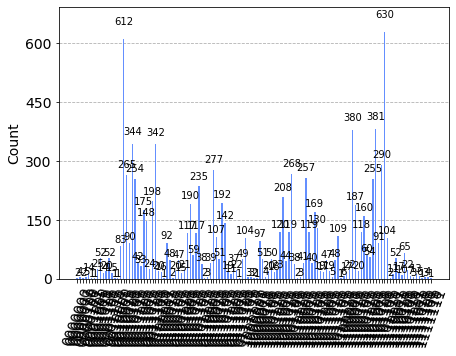

In [21]:
backend = Aer.get_backend('aer_simulator')

def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

beta, gamma = res.x

qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                          [beta], [gamma])

counts = backend.run(qc.decompose().decompose(), seed_simulator=10, shots=10000).result().get_counts()


# Print out bitstring

print(counts)
s = []
max_val = 0
for _ in counts.values():
    s.append(_)

s.sort()
viz = s[-2:]
for k, v in counts.items():
    if v in viz:
        print(k[::-1])

print(sum(s))

plot_histogram(counts)